In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from sklearn.metrics import roc_curve
from keras.utils import np_utils
from tqdm import tqdm
import pandas as pd
import numpy as np
import librosa 
import librosa.display
import pylab
import cv2
import os
import matplotlib.pyplot as plt

---
# 1-Prepare Data
---



## Download Data

In [ ]:
#!git clone https://github.com/iiscleap/Coswara-Data.git

Cloning into 'Coswara-Data'...
remote: Enumerating objects: 559, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (30/30), done.


In [ ]:
'''
rt_dir = '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data'
import glob
import os
for each in os.listdir(rt_dir):
    if os.path.isdir(os.path.join(rt_dir,each)) and each != '.git':
        print(each)
        !cat {os.path.join(rt_dir, each,'')}*.tar.gz.* > {os.path.join(rt_dir, each,'')}combined_file.tar.gz
        !tar -xzf {os.path.join(rt_dir, each,'')}combined_file.tar.gz -C {rt_dir}
subset = glob.glob('/content/Coswara-Data/*/*.tar.gz.*') + glob.glob('/content/Coswara-Data/*/combined_data.tar.gz')
[os.remove(x) for x in subset];
'''

In [3]:
'''
!wget https://zenodo.org/record/4048312/files/public_dataset.zip?download=1
!mv public_dataset.zip?download=1 public_dataset.zip
!unzip -q public_dataset.zip
!mkdir 'custom_dataset'
'''

--2021-05-03 21:56:35--  https://zenodo.org/record/4048312/files/public_dataset.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77, 192.65.187.5, 192.91.245.85, ...
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 951442487 (907M) [application/octet-stream]
Saving to: ‘public_dataset.zip?download=1’

public_dataset.zip? 100%[===================>] 907.37M  5.63MB/s    in 2m 43s  

2021-05-03 21:59:24 (5.57 MB/s) - ‘public_dataset.zip?download=1’ saved [951442487/951442487]



In [2]:
names   = ['ID','Fever/MP','ORC','STATUS','DIR','DataSet']
join_by = pd.read_csv('/home/sumukhmlohit/my_project_dir/virufy-covid/cough//Coswara-Data/combined_data.csv')

import glob
df_list = []
for path in tqdm(glob.glob('/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/*/*/cough-shallow.wav')):
      temp = pd.DataFrame(columns=['id','DIR'])
      temp['id'] = [path.split('/')[-2]]
      temp['DIR'] = [path]
      temp = pd.merge(left=temp,right=join_by,on='id',how='inner')

      temp['fomp']= (temp['fever']| temp['mp']).apply(int)
      temp['oths']= (temp['cld']|temp['asthma']|temp['cold']|temp['st']|temp['pneumonia']).apply(int)
      temp        = temp[['id','covid_status','DIR','fomp','oths']]
      df_list.append(temp.rename(columns={'id':'ID','covid_status':'STATUS','DIR':'DIR','fomp':'Fever/MP','oths':'ORC'}))
CosData1=pd.concat(df_list)
CosData1['DataSet'] = 'coswara'
CosData1.head()

100%|██████████| 1643/1643 [00:25<00:00, 64.24it/s]


,ID,STATUS,DIR,Fever/MP,ORC,DataSet
0,Tvdak0zflIVWdvWsNj7l9Ur0k3m1,positive_mild,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,0,coswara
0,nCejocB61DU95Gz2gEcPeH0N2pm1,no_resp_illness_exposed,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,1,coswara
0,Cd7fkliPM2ZUM1skytvoU2vD8jK2,positive_asymp,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,0,coswara
0,yZtohTVxlSauCUNuIIEUcdIA2TJ3,healthy,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,0,coswara
0,oeOuvTlUMEfWPcNOA4EnTk5Bh4K2,healthy,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,0,coswara


In [3]:
names   = ['ID','Fever/MP','ORC','STATUS','DIR_SPEECH','DataSet']
join_by = pd.read_csv('/home/sumukhmlohit/my_project_dir/virufy-covid/cough//Coswara-Data/combined_data.csv')

import glob
df_list = []
for path in tqdm(glob.glob('/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/*/*/counting-fast.wav')):
      temp = pd.DataFrame(columns=['id','DIR_SPEECH'])
      temp['id'] = [path.split('/')[-2]]
      temp['DIR_SPEECH'] = [path]
      temp = pd.merge(left=temp,right=join_by,on='id',how='inner')

      temp['fomp']= (temp['fever']| temp['mp']).apply(int)
      temp['oths']= (temp['cld']|temp['asthma']|temp['cold']|temp['st']|temp['pneumonia']).apply(int)
      temp        = temp[['id','covid_status','DIR_SPEECH','fomp','oths']]
      df_list.append(temp.rename(columns={'id':'ID','covid_status':'STATUS','DIR_SPEECH':'DIR_SPEECH','fomp':'Fever/MP','oths':'ORC'}))
CosData2=pd.concat(df_list)
CosData2['DataSet'] = 'coswara'
CosData2.head()

100%|██████████| 1645/1645 [00:26<00:00, 62.42it/s]


,ID,STATUS,DIR_SPEECH,Fever/MP,ORC,DataSet
0,Tvdak0zflIVWdvWsNj7l9Ur0k3m1,positive_mild,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,0,coswara
0,nCejocB61DU95Gz2gEcPeH0N2pm1,no_resp_illness_exposed,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,1,coswara
0,Cd7fkliPM2ZUM1skytvoU2vD8jK2,positive_asymp,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,0,coswara
0,yZtohTVxlSauCUNuIIEUcdIA2TJ3,healthy,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,0,coswara
0,oeOuvTlUMEfWPcNOA4EnTk5Bh4K2,healthy,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,0,coswara


In [4]:
CosData2.head()

,ID,STATUS,DIR_SPEECH,Fever/MP,ORC,DataSet
0,Tvdak0zflIVWdvWsNj7l9Ur0k3m1,positive_mild,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,0,coswara
0,nCejocB61DU95Gz2gEcPeH0N2pm1,no_resp_illness_exposed,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,1,coswara
0,Cd7fkliPM2ZUM1skytvoU2vD8jK2,positive_asymp,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,0,coswara
0,yZtohTVxlSauCUNuIIEUcdIA2TJ3,healthy,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,0,coswara
0,oeOuvTlUMEfWPcNOA4EnTk5Bh4K2,healthy,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,0,coswara


In [7]:
names   = ['ID','Fever/MP','ORC','STATUS','DIR_SPEECH','DataSet']
join_by = pd.read_csv('/home/sumukhmlohit/my_project_dir/virufy-covid/cough//Coswara-Data/combined_data.csv')

import glob
df_list = []
for path in tqdm(glob.glob('/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/*/*/breathing-shallow.wav')):
      temp = pd.DataFrame(columns=['id','DIR_BREATH'])
      temp['id'] = [path.split('/')[-2]]
      temp['DIR_BREATH'] = [path]
      temp = pd.merge(left=temp,right=join_by,on='id',how='inner')

      temp['fomp']= (temp['fever']| temp['mp']).apply(int)
      temp['oths']= (temp['cld']|temp['asthma']|temp['cold']|temp['st']|temp['pneumonia']).apply(int)
      temp        = temp[['id','covid_status','DIR_BREATH','fomp','oths']]
      df_list.append(temp.rename(columns={'id':'ID','covid_status':'STATUS','DIR_BREATH':'DIR_BREATH','fomp':'Fever/MP','oths':'ORC'}))
CosData3=pd.concat(df_list)
CosData3['DataSet'] = 'coswara'
CosData3.head()

100%|██████████| 1645/1645 [00:23<00:00, 70.41it/s]


,ID,STATUS,DIR_BREATH,Fever/MP,ORC,DataSet
0,Tvdak0zflIVWdvWsNj7l9Ur0k3m1,positive_mild,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,0,coswara
0,nCejocB61DU95Gz2gEcPeH0N2pm1,no_resp_illness_exposed,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,1,coswara
0,Cd7fkliPM2ZUM1skytvoU2vD8jK2,positive_asymp,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,0,coswara
0,yZtohTVxlSauCUNuIIEUcdIA2TJ3,healthy,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,0,coswara
0,oeOuvTlUMEfWPcNOA4EnTk5Bh4K2,healthy,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,0,coswara


In [8]:
CosData1.reset_index(drop=True, inplace=True)
CosData2.reset_index(drop=True, inplace=True)
CosData3.reset_index(drop=True, inplace=True)
CosData=pd.concat([CosData1, CosData2,CosData3], axis=1)

In [11]:
CosData.head()

,ID,STATUS,DIR,Fever/MP,ORC,DataSet,ID,STATUS,DIR_SPEECH,Fever/MP,ORC,DataSet,ID,STATUS,DIR_BREATH,Fever/MP,ORC,DataSet
0,Tvdak0zflIVWdvWsNj7l9Ur0k3m1,positive_mild,/home/sumukhmlohit/my_project_dir/virufy-covid...,0.0,0.0,coswara,Tvdak0zflIVWdvWsNj7l9Ur0k3m1,positive_mild,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,0,coswara,Tvdak0zflIVWdvWsNj7l9Ur0k3m1,positive_mild,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,0,coswara
1,nCejocB61DU95Gz2gEcPeH0N2pm1,no_resp_illness_exposed,/home/sumukhmlohit/my_project_dir/virufy-covid...,0.0,1.0,coswara,nCejocB61DU95Gz2gEcPeH0N2pm1,no_resp_illness_exposed,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,1,coswara,nCejocB61DU95Gz2gEcPeH0N2pm1,no_resp_illness_exposed,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,1,coswara
2,Cd7fkliPM2ZUM1skytvoU2vD8jK2,positive_asymp,/home/sumukhmlohit/my_project_dir/virufy-covid...,0.0,0.0,coswara,Cd7fkliPM2ZUM1skytvoU2vD8jK2,positive_asymp,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,0,coswara,Cd7fkliPM2ZUM1skytvoU2vD8jK2,positive_asymp,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,0,coswara
3,yZtohTVxlSauCUNuIIEUcdIA2TJ3,healthy,/home/sumukhmlohit/my_project_dir/virufy-covid...,0.0,0.0,coswara,yZtohTVxlSauCUNuIIEUcdIA2TJ3,healthy,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,0,coswara,yZtohTVxlSauCUNuIIEUcdIA2TJ3,healthy,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,0,coswara
4,oeOuvTlUMEfWPcNOA4EnTk5Bh4K2,healthy,/home/sumukhmlohit/my_project_dir/virufy-covid...,0.0,0.0,coswara,oeOuvTlUMEfWPcNOA4EnTk5Bh4K2,healthy,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,0,coswara,oeOuvTlUMEfWPcNOA4EnTk5Bh4K2,healthy,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,0,coswara


In [12]:
CosData = CosData.loc[:,~CosData.columns.duplicated()]

In [13]:
CosData.head()

,ID,STATUS,DIR,Fever/MP,ORC,DataSet,DIR_SPEECH,DIR_BREATH
0,Tvdak0zflIVWdvWsNj7l9Ur0k3m1,positive_mild,/home/sumukhmlohit/my_project_dir/virufy-covid...,0.0,0.0,coswara,/home/sumukhmlohit/my_project_dir/virufy-covid...,/home/sumukhmlohit/my_project_dir/virufy-covid...
1,nCejocB61DU95Gz2gEcPeH0N2pm1,no_resp_illness_exposed,/home/sumukhmlohit/my_project_dir/virufy-covid...,0.0,1.0,coswara,/home/sumukhmlohit/my_project_dir/virufy-covid...,/home/sumukhmlohit/my_project_dir/virufy-covid...
2,Cd7fkliPM2ZUM1skytvoU2vD8jK2,positive_asymp,/home/sumukhmlohit/my_project_dir/virufy-covid...,0.0,0.0,coswara,/home/sumukhmlohit/my_project_dir/virufy-covid...,/home/sumukhmlohit/my_project_dir/virufy-covid...
3,yZtohTVxlSauCUNuIIEUcdIA2TJ3,healthy,/home/sumukhmlohit/my_project_dir/virufy-covid...,0.0,0.0,coswara,/home/sumukhmlohit/my_project_dir/virufy-covid...,/home/sumukhmlohit/my_project_dir/virufy-covid...
4,oeOuvTlUMEfWPcNOA4EnTk5Bh4K2,healthy,/home/sumukhmlohit/my_project_dir/virufy-covid...,0.0,0.0,coswara,/home/sumukhmlohit/my_project_dir/virufy-covid...,/home/sumukhmlohit/my_project_dir/virufy-covid...


In [14]:
CosData['ID']

0       Tvdak0zflIVWdvWsNj7l9Ur0k3m1
1       nCejocB61DU95Gz2gEcPeH0N2pm1
2       Cd7fkliPM2ZUM1skytvoU2vD8jK2
3       yZtohTVxlSauCUNuIIEUcdIA2TJ3
4       oeOuvTlUMEfWPcNOA4EnTk5Bh4K2
                    ...             
1640    YqPKZEEwQ6N51vs5ztJn2a1nVBN2
1641    IFMid2LmeCTSQAFaL8wTSUg20No2
1642    56HPUhHPM9UEksAVgCDbQZcxsuZ2
1643                             NaN
1644                             NaN
Name: ID, Length: 1645, dtype: object

In [48]:
CosData.shape

(1645, 8)

In [54]:
CosData[CosData['DIR'].isnull()]

,ID,STATUS,DIR,Fever/MP,ORC,DataSet,DIR_SPEECH,DIR_BREATH
1643,NaN,NaN,NaN,NaN,NaN,NaN,/home/sumukhmlohit/my_project_dir/virufy-covid...,/home/sumukhmlohit/my_project_dir/virufy-covid...
1644,NaN,NaN,NaN,NaN,NaN,NaN,/home/sumukhmlohit/my_project_dir/virufy-covid...,/home/sumukhmlohit/my_project_dir/virufy-covid...


## Prepare dataset

In [7]:
'''
coughvid  = '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/public_dataset/'
custpath  = '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_cough2/' #Where mel spec images will be stored

VidData   = pd.read_csv(os.path.join(coughvid,'metadata_compiled.csv'),header=0)
VidData   = VidData.loc[VidData['cough_detected'] >= 0.9][['uuid','fever_muscle_pain','respiratory_condition','status']]
VidData.dropna(inplace=True)

extradata = VidData.loc[VidData['status']=='COVID-19']
notradata = VidData.loc[VidData['status']!='COVID-19'][0:1000]

TotData   = pd.concat([extradata,notradata],ignore_index= True)
TotData['DIR'] = coughvid + TotData['uuid'] + '.webm'
TotData['DataSet'] = 'coughvid'
TotData['fever_muscle_pain']    = TotData['fever_muscle_pain'].apply(int)
TotData['respiratory_condition']= TotData['respiratory_condition'].apply(int)
TotData   = pd.concat([CosData,TotData.rename(columns={'uuid':'ID','status':'STATUS','fever_muscle_pain':'Fever/MP','respiratory_condition':'ORC'})])
TotData   = TotData.sample(frac=1).reset_index(drop=True)
TotData.head()
'''

,ID,STATUS,DIR,Fever/MP,ORC,DataSet
0,aohEEUYh09Nbb1k0HlGwxPcuD663,resp_illness_not_identified,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,0,coswara
1,13cc16ff-2b44-4740-b7f4-e80cf7404d30,healthy,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,0,coughvid
2,B0biFhyqjzNmtEjWHSH9lQYBB2c2,no_resp_illness_exposed,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,0,coswara
3,0ef787a1-e603-496e-9ce7-6252e3f1a68a,healthy,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,0,coughvid
4,7MWN4jSmv3QD2sRi12K1BNjmct83,healthy,/home/sumukhmlohit/my_project_dir/virufy-covid...,0,0,coswara


## Feature Extraction

In [39]:
!mkdir custom_dataset_speech

In [15]:
custpath  = '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_cough2/'
custpathsp= '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_speech'
custpathb='/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_breath'
def feature_extractorsp(row):

  name     = row[0]
  try:
    audio,sr = librosa.load(row[6])
    #For MFCCS 
    mfccs    = librosa.feature.mfcc(y=audio,sr=sr, n_mfcc=39)
    mfccsscaled = np.mean(mfccs.T,axis=0)
    
    #Mel Spectogram
    plt.axis('off') # no axis
    plt.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
    melspec  = librosa.feature.melspectrogram(y=audio,sr=sr)
    s_db     = librosa.power_to_db(melspec, ref=np.max)
    librosa.display.specshow(s_db)

    savepath = os.path.join(custpathsp,name+'.png')
    plt.savefig(savepath, bbox_inches=None, pad_inches=0)
    plt.close()
  except:
    print('File cannot open')
    return None,None
  return mfccsscaled,savepath

features = []
diagnoses= []
imgpaths = []


In [16]:
def feature_extractorb(row):

  name     = row[0]
  try:
    audio,sr = librosa.load(row[7])
    #For MFCCS 
    mfccs    = librosa.feature.mfcc(y=audio,sr=sr, n_mfcc=39)
    mfccsscaled = np.mean(mfccs.T,axis=0)
    
    #Mel Spectogram
    plt.axis('off') # no axis
    plt.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
    melspec  = librosa.feature.melspectrogram(y=audio,sr=sr)
    s_db     = librosa.power_to_db(melspec, ref=np.max)
    librosa.display.specshow(s_db)

    savepath = os.path.join(custpathb,name+'.png')
    plt.savefig(savepath, bbox_inches=None, pad_inches=0)
    plt.close()
  except:
    print('File cannot open')
    return None,None
  return mfccsscaled,savepath

features = []
diagnoses= []
imgpaths = []


In [17]:
def feature_extractor(row):

  name     = row[0]
  try:
    audio,sr = librosa.load(row[2])
    #For MFCCS 
    mfccs    = librosa.feature.mfcc(y=audio,sr=sr, n_mfcc=39)
    mfccsscaled = np.mean(mfccs.T,axis=0)
    
    #Mel Spectogram
    plt.axis('off') # no axis
    plt.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
    melspec  = librosa.feature.melspectrogram(y=audio,sr=sr)
    s_db     = librosa.power_to_db(melspec, ref=np.max)
    librosa.display.specshow(s_db)

    savepath = os.path.join(custpath,name+'.png')
    plt.savefig(savepath, bbox_inches=None, pad_inches=0)
    plt.close()
  except:
    print('File cannot open')
    return None,None
  return mfccsscaled,savepath

features = []
diagnoses= []
imgpaths = []

In [18]:
featuresp=[]
imgpathsp=[]

In [19]:
custpathsp

'/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_speech'

In [21]:
for row in tqdm(CosData.values):
  print(row[7])

 36%|███▋      | 599/1645 [00:00<00:00, 2967.77it/s]

/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200824/Tvdak0zflIVWdvWsNj7l9Ur0k3m1/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200824/nCejocB61DU95Gz2gEcPeH0N2pm1/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200824/Cd7fkliPM2ZUM1skytvoU2vD8jK2/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200824/yZtohTVxlSauCUNuIIEUcdIA2TJ3/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200824/oeOuvTlUMEfWPcNOA4EnTk5Bh4K2/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200824/vSVws79jhxXr1iQrtbvhchHaHCE3/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200824/SCsTjixqXmWvyjniXtg7Pv54Amw2/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200824/xYCukI9rgMeslwjIYWheFtyZ6zk1/breathing-shal

 54%|█████▍    | 896/1645 [00:00<00:00, 2604.24it/s]

/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20210406/Fh3hBZZRh2UXXicTNGMei8ikbSu2/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20210406/NxqOq1i4PtUiqBxV1wFUII9SQj43/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20210406/zo7vWVJHp5W8ojnfNUogikQTu2K2/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20210406/SwW5rQwDVJRdGLNmwOm1DEjtslB2/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20210406/c18b81Qa5YY2RbEzblDNxMNQE312/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20210406/IimA0GnOm7ZR4nEr8k0kG4eaR7A3/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20210406/JhH2YMg1TpWG7RqVv3jOTXFmJZt2/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20210406/yiVfb7qpTOXWhTQITq6P4zqGtXt2/breathing-shal

100%|██████████| 1645/1645 [00:00<00:00, 2920.63it/s]

/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200415/4EAxuOcgN5d81JCmqo2YxXlxYNL2/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200415/7yQ29b3Q1KfOIk5K1MSeGTsWqGB2/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200415/GZM32y1Sy6X9D9hfrrvpTdPfmoV2/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200415/269e2kDksfRXKVHNXf4ACl9JUVm1/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200415/HltnpdE31PPFAFYRdJXRXokmdUF2/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200415/TIFqRMyFsNVEYSMu9P05PF5N2Px1/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200415/HxbOUFGbq4fKbs0nTLUQ5UmlZ9y2/breathing-shallow.wav
/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200415/g0gdNMhQIbUlZRTod20TdtqafgJ3/breathing-shal

  1%|          | 11/1645 [00:09<20:41,  1.32it/s]

File cannot open


  4%|▍         | 68/1645 [00:48<17:09,  1.53it/s]

File cannot open


  5%|▍         | 76/1645 [00:54<19:01,  1.37it/s]

File cannot open


  5%|▍         | 81/1645 [00:56<15:46,  1.65it/s]

File cannot open


  7%|▋         | 111/1645 [01:18<21:08,  1.21it/s]

File cannot open


 11%|█         | 177/1645 [02:23<23:11,  1.05it/s]

File cannot open


 14%|█▍        | 232/1645 [03:14<30:04,  1.28s/it]

File cannot open


 14%|█▍        | 234/1645 [03:15<21:23,  1.10it/s]

File cannot open


 45%|████▌     | 742/1645 [11:20<14:55,  1.01it/s]  

File cannot open


 47%|████▋     | 778/1645 [12:11<18:18,  1.27s/it]

File cannot open


 50%|████▉     | 815/1645 [12:49<10:16,  1.35it/s]

File cannot open


 50%|████▉     | 819/1645 [12:54<13:04,  1.05it/s]

File cannot open


 56%|█████▌    | 917/1645 [14:32<11:30,  1.05it/s]

File cannot open


 56%|█████▌    | 921/1645 [14:36<11:29,  1.05it/s]

File cannot open


 62%|██████▏   | 1026/1645 [16:27<09:39,  1.07it/s]

File cannot open


 63%|██████▎   | 1033/1645 [16:31<06:20,  1.61it/s]

File cannot open


 63%|██████▎   | 1041/1645 [16:39<09:14,  1.09it/s]

File cannot open


 64%|██████▍   | 1057/1645 [16:56<11:29,  1.17s/it]

File cannot open


 64%|██████▍   | 1061/1645 [16:59<09:47,  1.01s/it]

File cannot open


 65%|██████▍   | 1068/1645 [17:06<11:00,  1.14s/it]

File cannot open


 69%|██████▊   | 1130/1645 [18:08<06:26,  1.33it/s]

File cannot open


 77%|███████▋  | 1263/1645 [21:40<18:32,  2.91s/it]

File cannot open


 79%|███████▉  | 1307/1645 [23:18<10:18,  1.83s/it]

File cannot open


 83%|████████▎ | 1358/1645 [24:47<08:42,  1.82s/it]

File cannot open


 83%|████████▎ | 1365/1645 [24:54<05:23,  1.15s/it]

File cannot open


 84%|████████▎ | 1375/1645 [25:06<04:48,  1.07s/it]

File cannot open


 87%|████████▋ | 1427/1645 [25:58<03:38,  1.00s/it]

File cannot open


 91%|█████████ | 1491/1645 [29:53<08:21,  3.26s/it]

File cannot open


 94%|█████████▎| 1540/1645 [31:54<02:04,  1.18s/it]

File cannot open


100%|█████████▉| 1644/1645 [33:46<00:00,  1.15it/s]

File cannot open


100%|██████████| 1645/1645 [33:47<00:00,  1.23s/it]

File cannot open


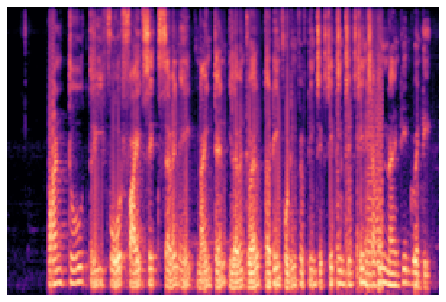

In [22]:
j=0
for row in tqdm(CosData.values):
  mfccsp,savepathsp  = feature_extractorsp(row)
  featuresp.append(mfccsp)
  imgpathsp.append(savepathsp)

  1%|          | 11/1645 [00:11<30:14,  1.11s/it]

File cannot open


  2%|▏         | 27/1645 [00:25<18:17,  1.47it/s]

File cannot open


  4%|▍         | 68/1645 [01:04<28:23,  1.08s/it]

File cannot open


  5%|▍         | 76/1645 [01:16<31:54,  1.22s/it]

File cannot open


  5%|▍         | 81/1645 [01:22<33:50,  1.30s/it]

File cannot open


  7%|▋         | 111/1645 [01:53<21:36,  1.18it/s]

File cannot open


 11%|█         | 174/1645 [03:19<58:21,  2.38s/it]  

File cannot open


 11%|█         | 177/1645 [03:23<44:08,  1.80s/it]

File cannot open


 14%|█▍        | 232/1645 [04:50<47:25,  2.01s/it]  

File cannot open


 14%|█▍        | 234/1645 [04:51<32:53,  1.40s/it]

File cannot open


 37%|███▋      | 606/1645 [15:26<30:07,  1.74s/it]  

File cannot open


 45%|████▌     | 742/1645 [18:25<15:31,  1.03s/it]

File cannot open


 47%|████▋     | 779/1645 [19:32<23:53,  1.66s/it]

File cannot open


 49%|████▉     | 814/1645 [20:14<24:32,  1.77s/it]

File cannot open


 50%|████▉     | 819/1645 [20:19<18:27,  1.34s/it]

File cannot open


 56%|█████▌    | 917/1645 [25:53<11:36,  1.04it/s]  

File cannot open


 56%|█████▌    | 921/1645 [25:56<10:28,  1.15it/s]

File cannot open


 62%|██████▏   | 1027/1645 [28:40<09:58,  1.03it/s]

File cannot open


 63%|██████▎   | 1032/1645 [28:48<12:19,  1.21s/it]

File cannot open


 63%|██████▎   | 1041/1645 [28:58<10:55,  1.09s/it]

File cannot open


 64%|██████▍   | 1057/1645 [29:18<10:15,  1.05s/it]

File cannot open


 65%|██████▍   | 1068/1645 [29:32<16:18,  1.70s/it]

File cannot open


 69%|██████▊   | 1130/1645 [31:44<11:52,  1.38s/it]

File cannot open


 79%|███████▉  | 1306/1645 [36:02<08:03,  1.43s/it]

File cannot open


 83%|████████▎ | 1365/1645 [37:14<06:17,  1.35s/it]

File cannot open


 84%|████████▎ | 1375/1645 [37:25<04:35,  1.02s/it]

File cannot open


 90%|█████████ | 1481/1645 [39:36<03:03,  1.12s/it]

File cannot open


 90%|█████████ | 1488/1645 [39:55<04:59,  1.91s/it]

File cannot open


 91%|█████████ | 1491/1645 [39:57<02:53,  1.13s/it]

File cannot open


 94%|█████████▎| 1539/1645 [40:58<02:39,  1.51s/it]

File cannot open


100%|█████████▉| 1644/1645 [43:37<00:00,  1.04it/s]

File cannot open


100%|██████████| 1645/1645 [43:38<00:00,  1.59s/it]

File cannot open


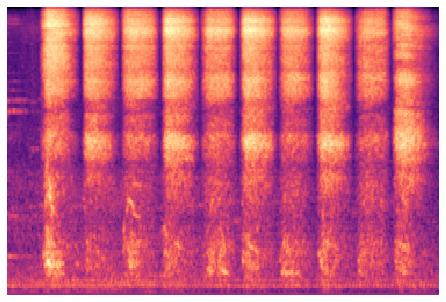

In [28]:
featureb=[]
imgpathb=[]
for row in tqdm(CosData.values):
  mfccb,savepathb  = feature_extractorb(row)
  featureb.append(mfccb)
  imgpathb.append(savepathb)

In [29]:
for row in tqdm(CosData.values):
  name=row[0]
  mfccs,savepath  = feature_extractor(row)
  features.append(mfccs)
  imgpaths.append(savepath)
  diagnoses.append([row[3],row[4]])

  1%|          | 11/1645 [00:08<19:19,  1.41it/s]

File cannot open


  4%|▍         | 69/1645 [00:44<14:32,  1.81it/s]

File cannot open


  5%|▍         | 76/1645 [00:50<20:53,  1.25it/s]

File cannot open


  5%|▍         | 81/1645 [00:53<17:07,  1.52it/s]

File cannot open


  7%|▋         | 111/1645 [01:16<17:31,  1.46it/s]

File cannot open


 11%|█         | 177/1645 [02:02<18:44,  1.31it/s]

File cannot open


 14%|█▍        | 232/1645 [02:44<17:51,  1.32it/s]

File cannot open


 14%|█▍        | 234/1645 [02:44<12:13,  1.92it/s]

File cannot open


 45%|████▌     | 741/1645 [12:19<12:02,  1.25it/s]   

File cannot open


 47%|████▋     | 778/1645 [12:54<12:05,  1.20it/s]

File cannot open


 49%|████▉     | 814/1645 [13:26<13:43,  1.01it/s]

File cannot open


 50%|████▉     | 819/1645 [13:29<09:57,  1.38it/s]

File cannot open


 56%|█████▌    | 917/1645 [14:57<11:25,  1.06it/s]

File cannot open


 56%|█████▌    | 921/1645 [14:59<08:36,  1.40it/s]

File cannot open


 62%|██████▏   | 1026/1645 [16:43<13:30,  1.31s/it]

File cannot open


 63%|██████▎   | 1032/1645 [16:49<12:26,  1.22s/it]

File cannot open


 63%|██████▎   | 1041/1645 [16:58<10:11,  1.01s/it]

File cannot open


 64%|██████▍   | 1057/1645 [17:09<06:46,  1.45it/s]

File cannot open


 65%|██████▍   | 1068/1645 [17:22<11:41,  1.22s/it]

File cannot open


 71%|███████▏  | 1173/1645 [18:59<07:12,  1.09it/s]

File cannot open


 79%|███████▉  | 1305/1645 [20:50<05:07,  1.10it/s]

File cannot open


 83%|████████▎ | 1364/1645 [21:41<05:07,  1.09s/it]

File cannot open


 84%|████████▎ | 1374/1645 [21:51<04:44,  1.05s/it]

File cannot open


 87%|████████▋ | 1425/1645 [22:35<02:56,  1.25it/s]

File cannot open


 90%|█████████ | 1487/1645 [24:05<03:27,  1.31s/it]

File cannot open


 91%|█████████ | 1489/1645 [24:13<07:14,  2.79s/it]

File cannot open


 93%|█████████▎| 1537/1645 [25:25<01:49,  1.01s/it]

File cannot open


 97%|█████████▋| 1603/1645 [26:28<00:27,  1.53it/s]

File cannot open


100%|██████████| 1645/1645 [26:58<00:00,  1.02it/s]

File cannot open
File cannot open


In [23]:
CosData

,ID,STATUS,DIR,Fever/MP,ORC,DataSet,DIR_SPEECH,DIR_BREATH
0,Tvdak0zflIVWdvWsNj7l9Ur0k3m1,positive_mild,/home/sumukhmlohit/my_project_dir/virufy-covid...,0.0,0.0,coswara,/home/sumukhmlohit/my_project_dir/virufy-covid...,/home/sumukhmlohit/my_project_dir/virufy-covid...
1,nCejocB61DU95Gz2gEcPeH0N2pm1,no_resp_illness_exposed,/home/sumukhmlohit/my_project_dir/virufy-covid...,0.0,1.0,coswara,/home/sumukhmlohit/my_project_dir/virufy-covid...,/home/sumukhmlohit/my_project_dir/virufy-covid...
2,Cd7fkliPM2ZUM1skytvoU2vD8jK2,positive_asymp,/home/sumukhmlohit/my_project_dir/virufy-covid...,0.0,0.0,coswara,/home/sumukhmlohit/my_project_dir/virufy-covid...,/home/sumukhmlohit/my_project_dir/virufy-covid...
3,yZtohTVxlSauCUNuIIEUcdIA2TJ3,healthy,/home/sumukhmlohit/my_project_dir/virufy-covid...,0.0,0.0,coswara,/home/sumukhmlohit/my_project_dir/virufy-covid...,/home/sumukhmlohit/my_project_dir/virufy-covid...
4,oeOuvTlUMEfWPcNOA4EnTk5Bh4K2,healthy,/home/sumukhmlohit/my_project_dir/virufy-covid...,0.0,0.0,coswara,/home/sumukhmlohit/my_project_dir/virufy-covid...,/home/sumukhmlohit/my_project_dir/virufy-covid...
...,...,...,...,...,...,...,...,...
1640,YqPKZEEwQ6N51vs5ztJn2a1nVBN2,no_resp_illness_exposed,/home/sumukhmlohit/my_project_dir/virufy-covid...,0.0,0.0,coswara,/home/sumukhmlohit/my_project_dir/virufy-covid...,/home/sumukhmlohit/my_project_dir/virufy-covid...
1641,IFMid2LmeCTSQAFaL8wTSUg20No2,positive_mild,/home/sumukhmlohit/my_project_dir/virufy-covid...,0.0,0.0,coswara,/home/sumukhmlohit/my_project_dir/virufy-covid...,/home/sumukhmlohit/my_project_dir/virufy-covid...
1642,56HPUhHPM9UEksAVgCDbQZcxsuZ2,positive_mild,/home/sumukhmlohit/my_project_dir/virufy-covid...,0.0,0.0,coswara,/home/sumukhmlohit/my_project_dir/virufy-covid...,/home/sumukhmlohit/my_project_dir/virufy-covid...
1643,NaN,NaN,NaN,NaN,NaN,NaN,/home/sumukhmlohit/my_project_dir/virufy-covid...,/home/sumukhmlohit/my_project_dir/virufy-covid...


In [121]:
imgpathb

['/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_breath/Tvdak0zflIVWdvWsNj7l9Ur0k3m1.png',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_breath/nCejocB61DU95Gz2gEcPeH0N2pm1.png',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_breath/Cd7fkliPM2ZUM1skytvoU2vD8jK2.png',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_breath/yZtohTVxlSauCUNuIIEUcdIA2TJ3.png',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_breath/oeOuvTlUMEfWPcNOA4EnTk5Bh4K2.png',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_breath/vSVws79jhxXr1iQrtbvhchHaHCE3.png',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_breath/SCsTjixqXmWvyjniXtg7Pv54Amw2.png',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_breath/xYCukI9rgMeslwjIYWheFtyZ6zk1.png',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_breath/ptuwF1pj4ibIoVuZmt4nKb5naiZ

In [47]:
imgpathsp

['/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_speech/Tvdak0zflIVWdvWsNj7l9Ur0k3m1.png',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_speech/nCejocB61DU95Gz2gEcPeH0N2pm1.png',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_speech/Cd7fkliPM2ZUM1skytvoU2vD8jK2.png',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_speech/yZtohTVxlSauCUNuIIEUcdIA2TJ3.png',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_speech/oeOuvTlUMEfWPcNOA4EnTk5Bh4K2.png',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_speech/vSVws79jhxXr1iQrtbvhchHaHCE3.png',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_speech/SCsTjixqXmWvyjniXtg7Pv54Amw2.png',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_speech/xYCukI9rgMeslwjIYWheFtyZ6zk1.png',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_dataset_speech/ptuwF1pj4ibIoVuZmt4nKb5naiZ

In [62]:
len(features)

1645

## Remove Nans





In [35]:
'''
isnone = lambda x: x is not None
label  = lambda x: 1 if x == 'positive_mild' or x =='positive_moderate' or x == 'COVID-19' else 0
cast_x = list(map(isnone,features))
cast_xs= list(map(isnone,featuresp))
cast_xb= list(map(isnone,featureb))
data_y = list(map(label,CosData['STATUS']))
'''

In [80]:
cast_xs==cast_x

False

In [85]:
cast_xs[1061]

False

In [166]:
features

[array([-5.8998969e+02,  3.9067333e+01, -2.3393484e+01,  1.6956741e+01,
        -1.6744072e+01,  1.5442015e+00, -1.2377095e+01, -5.6855674e+00,
        -9.1005983e+00, -2.4687433e+00,  7.2049558e-01, -8.2116413e+00,
         4.5465364e+00, -6.6524577e+00, -2.8332155e+00, -2.6696517e+00,
        -3.3237502e-01, -7.9120445e+00, -9.1984596e+00, -6.5887339e-02,
        -8.2565699e+00, -1.2529090e-01,  6.5873235e-02,  9.6177852e-01,
         1.0179029e+00, -2.0054517e+00,  1.3765626e+00, -3.4494917e+00,
        -2.9897771e+00, -3.3440557e-01, -2.1996002e+00, -3.3772826e+00,
        -6.4894581e-01,  8.2695633e-01, -1.5380304e+00, -2.1310582e+00,
         9.3110466e-01,  1.0954111e-01, -7.9136175e-01], dtype=float32),
 array([-4.3483212e+02,  8.1135086e+01, -3.0991131e+01, -7.5480633e+00,
        -1.1581133e+01,  1.7709301e+00, -1.6417452e+01, -8.4966116e+00,
        -5.9100056e+00, -4.1376570e-01,  6.3798308e+00, -4.2129502e+00,
        -3.4109011e+00, -1.4205825e+00,  5.5305403e-01, -6.9719

In [169]:
DATA[0]['MFCCS']

array([[-4.20370728e+02,  5.78924332e+01, -3.69376297e+01, ...,
        -3.20615917e-01, -5.04508853e-01,  8.04183483e-01],
       [-5.88154724e+02,  4.16470184e+01, -3.60774136e+00, ...,
         1.20238423e+00,  1.94367766e+00,  4.41060700e-02],
       [-3.55169189e+02,  6.69535141e+01, -1.21095905e+01, ...,
        -3.34235120e+00,  1.68237221e+00, -4.01701212e+00],
       ...,
       [-2.92552948e+02,  1.04501556e+02, -4.05532379e+01, ...,
         6.05896175e-01, -1.43617690e+00,  9.98539865e-01],
       [-7.58989258e+02,  1.81430893e+01, -1.10957708e+01, ...,
        -1.99648929e+00, -2.09329009e+00, -2.60779405e+00],
       [-5.34289490e+02,  3.21057281e+01, -1.47949095e+01, ...,
        -1.20302415e+00,  4.44630742e-01, -7.34616756e-01]], dtype=float32)

In [36]:
'''
data_x = [features[i] for i in range(len(features)) if cast_x[i] == True]
data_xx= [imgpaths[i] for i in range(len(imgpaths)) if cast_x[i] == True]
data_xp= [diagnoses[i]for i in range(len(diagnoses))if cast_x[i] == True]
data_xs = [featuresp[i] for i in range(len(featuresp)) if cast_xs[i] == True]
data_xxs= [imgpathsp[i] for i in range(len(imgpathsp)) if cast_xs[i] == True]
data_xb = [featureb[i] for i in range(len(featureb)) if cast_xs[i] == True]
data_xxb= [imgpathb[i] for i in range(len(imgpathb)) if cast_xs[i] == True]
data_y = [data_y[i] for i in range(len(features)) if cast_x[i] == True and cast_xs[i]==True]
'''

In [119]:
'''
data_x = data_x[: len(data_x) - 10]
data_xx = data_xx[: len(data_xx) - 10]
data_xp = data_xp[: len(data_xp) - 10]
data_xs = data_xs[: len(data_xs) - 10]
data_xxs = data_xxs[: len(data_xxs) - 10]
'''

In [124]:
cast_xb= list(map(isnone,featureb))
data_xb = [featureb[i] for i in range(len(featureb)) if cast_xb[i] == True]
data_xxb= [imgpathb[i] for i in range(len(imgpathb)) if cast_xb[i] == True]

## Prepare Data Splits
  n = NUM_shuf





In [125]:
#assert len(data_x) == len(data_xx) == len(data_xp) == len(data_xs) == len(data_xxs), "Data lengths do not match"

indices = np.arange(len(data_y))
NUM_shuf= 5
DATA    = {i:{} for i in range(NUM_shuf)}

for i in range(NUM_shuf):
  np.random.shuffle(indices)

  DATA[i]['MFCCS'] = np.array([data_x[i] for i in indices])
  DATA[i]['MEL']   = [data_xx[i] for i in indices]
  DATA[i]['EXTRA'] = np.array([data_xp[i] for i in indices])
  DATA[i]['MFCCSP'] = np.array([data_xs[i] for i in indices])
  DATA[i]['MELP']   = [data_xxs[i] for i in indices] 
  DATA[i]['MFCCB'] = np.array([data_xb[i] for i in indices])
  DATA[i]['MELB']   = [data_xxb[i] for i in indices] 
  DATA[i]['LABELS']= np.array([data_y[i] for i in indices])

In [78]:
np.arange(len(data_x))

array([   0,    1,    2, ..., 1612, 1613, 1614])

In [126]:
# Save extracted features
# Note: mel specs not saved
import pickle
pickle.dump( DATA, open( "loaded_data.pickle", "wb" ) )

In [132]:
DATA[0]['MFCCB'].shape

(1605, 39)

## Data Generator




In [127]:
class CustomDataset(tf.keras.utils.Sequence):
  def __init__(self,imgfiles,labels,batch_size,target_size=(64,64),shuffle=False,scale=255,n_classes=1,n_channels=3):
    self.batch_size = batch_size
    self.dim        = target_size
    self.labels     = labels
    self.imgfiles   = imgfiles
    self.n_classes  = n_classes
    self.shuffle    = shuffle
    self.n_channels = n_channels
    self.scale      = scale

    self.c          = 0
    self.on_epoch_end()

  def __len__(self):
    # returns the number of batches
    return int(np.floor(len(self.imgfiles) / self.batch_size))

  def __getitem__(self, index):
    # returns one batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Generate data
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.imgfiles))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)
  
  def __data_generation(self, list_IDs_temp):
    X = np.empty((self.batch_size, *self.dim, self.n_channels))
    y = np.empty((self.batch_size), dtype=int)

    # Generate data
    for i, ID in enumerate(list_IDs_temp):
        # Store sample
        img   = cv2.imread(self.imgfiles[ID])
        img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
        X[i,] = img / self.scale

        # Store class
        y[i] = self.labels[ID]

        self.c +=1
    return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)


class CustomPipeline(tf.keras.utils.Sequence):
  def __init__(self,data_x,data_y,batch_size=48,shuffle=False,n_classes=1):
    self.features   = data_x
    self.labels     = data_y
    self.batch_size = 48
    self.shuffle    = shuffle
    
    self.n_features = self.features.shape[1]
   
    self.n_classes  = 1
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.features) / self.batch_size))

  def __getitem__(self,index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.features))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self,indexes):
    X = np.empty((self.batch_size, self.n_features))
    y = np.empty((self.batch_size), dtype=int)

    for i, ID in enumerate(indexes):
      X[i,] = self.features[ID]
      y[i,] = self.labels[ID]
    return X, y

class MultipleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, Y, batch_size,target_size=(64,64)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)

  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X_batch = [X1_batch, X2_batch]
      return X_batch, Y_batch

class TripleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, X3, Y, batch_size,target_size=(64,64)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)
      self.genX3 = CustomPipeline(X3, Y, batch_size=batch_size,shuffle=False)
  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X3_batch, Y_batch = self.genX3.__getitem__(index)

      X_batch = [X1_batch, X2_batch, X3_batch]
      return X_batch, Y_batch

class FiveInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, X3,X4,X5,X6,X7, Y, batch_size,target_size=(64,64)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)#features
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)#images
      self.genX3 = CustomPipeline(X3, Y, batch_size=batch_size,shuffle=False)#features
      self.genX4 = CustomDataset (X4, Y, batch_size=batch_size,shuffle=False,target_size=target_size)#images
      self.genX5 = CustomPipeline(X5, Y, batch_size=batch_size,shuffle=False)#features
      
  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X3_batch, Y_batch = self.genX3.__getitem__(index)
      X4_batch, Y_batch = self.genX4.__getitem__(index)
      X5_batch, Y_batch = self.genX5.__getitem__(index)

      X_batch = [X1_batch, X2_batch, X3_batch,X4_batch, X5_batch]
      return X_batch, Y_batch    

class SevenInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, X3,X4,X5,X6,X7, Y, batch_size,target_size=(64,64)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)#features
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)#images
      self.genX3 = CustomPipeline(X3, Y, batch_size=batch_size,shuffle=False)#features
      self.genX4 = CustomDataset (X4, Y, batch_size=batch_size,shuffle=False,target_size=target_size)#images
      self.genX5 = CustomPipeline(X5, Y, batch_size=batch_size,shuffle=False)#features
      self.genX6 = CustomDataset (X6, Y, batch_size=batch_size,shuffle=False,target_size=target_size)#images
      self.genX7 = CustomPipeline(X7, Y, batch_size=batch_size,shuffle=False)#features
  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X3_batch, Y_batch = self.genX3.__getitem__(index)
      X4_batch, Y_batch = self.genX4.__getitem__(index)
      X5_batch, Y_batch = self.genX5.__getitem__(index)
      X6_batch, Y_batch = self.genX6.__getitem__(index)
      X7_batch, Y_batch = self.genX7.__getitem__(index)

      X_batch = [X1_batch, X2_batch, X3_batch,X4_batch, X5_batch, X6_batch,X7_batch]
      return X_batch, Y_batch

In [128]:
features

[array([-5.8998969e+02,  3.9067333e+01, -2.3393484e+01,  1.6956741e+01,
        -1.6744072e+01,  1.5442015e+00, -1.2377095e+01, -5.6855674e+00,
        -9.1005983e+00, -2.4687433e+00,  7.2049558e-01, -8.2116413e+00,
         4.5465364e+00, -6.6524577e+00, -2.8332155e+00, -2.6696517e+00,
        -3.3237502e-01, -7.9120445e+00, -9.1984596e+00, -6.5887339e-02,
        -8.2565699e+00, -1.2529090e-01,  6.5873235e-02,  9.6177852e-01,
         1.0179029e+00, -2.0054517e+00,  1.3765626e+00, -3.4494917e+00,
        -2.9897771e+00, -3.3440557e-01, -2.1996002e+00, -3.3772826e+00,
        -6.4894581e-01,  8.2695633e-01, -1.5380304e+00, -2.1310582e+00,
         9.3110466e-01,  1.0954111e-01, -7.9136175e-01], dtype=float32),
 array([-4.3483212e+02,  8.1135086e+01, -3.0991131e+01, -7.5480633e+00,
        -1.1581133e+01,  1.7709301e+00, -1.6417452e+01, -8.4966116e+00,
        -5.9100056e+00, -4.1376570e-01,  6.3798308e+00, -4.2129502e+00,
        -3.4109011e+00, -1.4205825e+00,  5.5305403e-01, -6.9719

---
# 3- Training and Evaluation
---

In [129]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class Evaluation(keras.callbacks.Callback):
  
  def __init__(self, val_data_gen, val_labels, test_data_gen, test_labels):
    super(Callback, self).__init__()
    self.test_data = test_data_gen
    self.val_labels = val_labels
    self.val_data = val_data_gen
    self.test_labels = test_labels

  def on_epoch_end(self, epoch, logs=None):
    y_preds = self.model.predict_generator(self.val_data)
    print(' | val_auc:', roc_auc_score(self.val_labels[:len(y_preds)], y_preds))

    y_preds = self.model.predict_generator(self.test_data)
    print(' | test_auc:', roc_auc_score(self.test_labels[:len(y_preds)], y_preds))


In [192]:
def build_model():
  '''Function to build ensemble model'''
  # First Model
  inp1   = Input(shape=39)
  lay1   = Dense(units=512,activation='relu',kernel_initializer='GlorotUniform')(inp1)
  lay2   = Dropout(0.4)(lay1)
  lay3   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay2)
  lay4   = Dropout(0.2)(lay3)

  # Second Model
  inp2   = Input(shape=(64,64,3))
  lay1_  = Conv2D(32, (3, 3), strides=(2, 2))(inp2)
  lay2_  = AveragePooling2D((2, 2), strides=(2,2))(lay1_)
  lay3_  = BatchNormalization()(lay2_)
  lay4_  = Activation('relu')(lay3_)

  lay5_  = Conv2D(64, (3, 3), padding="same") (lay4_)
  lay6_  = AveragePooling2D((2, 2), strides=(2,2)) (lay5_)
  lay7_  = BatchNormalization()(lay6_)
  lay8_  = Activation('relu')(lay7_)

  lay9_  = Conv2D(64, (3, 3), padding="same") (lay8_)
  lay10_ = AveragePooling2D((2, 2), strides=(2,2)) (lay9_)
  lay11_ = BatchNormalization()(lay10_)
  lay12_ = Activation('relu')(lay11_)

  lay13_ = Flatten()(lay12_)
  lay14_ = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay13_)
  lay15_ = Dropout(rate=0.5)(lay14_)

  # Third model
  inp4   = Input(shape=2)
  lay31  = Dense(units=16,activation='relu',kernel_initializer='GlorotUniform')(inp4)
  lay32  = Dropout(0.4)(lay31)
  lay33  = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay32)
  lay43  = Dropout(0.2)(lay33)
 
   # Fourth Model
  inp3   = Input(shape=39)
  lay51   = Dense(units=512,activation='relu',kernel_initializer='GlorotUniform')(inp3)
  lay52   = Dropout(0.4)(lay51)
  lay53   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay52)
  lay54   = Dropout(0.2)(lay53)

  

  lay65_  = Conv2D(64, (3, 3), padding="same") (lay54)
  lay66_  = AveragePooling2D((2, 2), strides=(2,2)) (lay65_)
  lay67_  = BatchNormalization()(lay66_)
  lay68_  = Activation('relu')(lay67_)

  lay69_  = Conv2D(64, (3, 3), padding="same") (lay68_)
  lay70_ = AveragePooling2D((2, 2), strides=(2,2)) (lay69_)
  lay71_ = BatchNormalization()(lay70_)
  lay72_ = Activation('relu')(lay71_)

    
  # Sixth model
  inp6   = Input(shape=2)
  lay81  = Dense(units=16,activation='relu',kernel_initializer='GlorotUniform')(inp6)
  lay82  = Dropout(0.4)(lay81)
  lay83  = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay82)
  lay84  = Dropout(0.2)(lay83)

  # Seventh model
  inp7   = Input(shape=2)
  lay91  = Dense(units=16,activation='relu',kernel_initializer='GlorotUniform')(inp7)
  lay92  = Dropout(0.4)(lay91)
  lay93  = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay92)
  lay94  = Dropout(0.2)(lay93)  
    
  # merge input models
  merge = concatenate([lay15_, lay4,lay43,lay75_,lay72_,lay84,lay94])

  # interpretation model
  hidden1 = Dense(64, activation='relu')(merge)
  hidden2 = Dense(64, activation='relu')(hidden1)
  output  = Dense(1, activation='sigmoid')(hidden2)
  MERGM   = Model(inputs=[inp1, inp2,inp3,inp4,inp5,inp6,inp7], outputs=output)

  return MERGM

In [179]:
#!mkdir cough_speech_models2

In [131]:
len(data_xb)

1613

In [193]:
# Create directory to save models
rt_sv_dir = '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/cough_speech_models2'

#!rm -r {rt_sv_dir}
#os.mkdir(rt_sv_dir)

# Run each split
for RUN in range(NUM_shuf):
  MERGM = build_model()

  MERGM.compile(
      optimizer = 'Adam',
      loss = 'BinaryCrossentropy',
      metrics=['AUC'])

  tfeatures = DATA[RUN]['MFCCS'][:int(0.7*len(data_x))]
  textra    = DATA[RUN]['EXTRA'][:int(0.7*len(data_x))]
  timgs     = DATA[RUN]['MEL'][:int(0.7*len(data_x))]
  labels    = DATA[RUN]['LABELS'][:int(0.7*len(data_y))]
  tfeaturesp = DATA[RUN]['MFCCSP'][:int(0.7*len(data_xs))]
  timgsp     = DATA[RUN]['MELP'][:int(0.7*len(data_xs))]
  tfeaturesb = DATA[RUN]['MFCCB'][:int(0.7*len(data_xb))]
  timgsb    = DATA[RUN]['MELB'][:int(0.7*len(data_xb))]

  test_features= DATA[RUN]['MFCCS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_extra   = DATA[RUN]['EXTRA'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_imgs    = DATA[RUN]['MEL'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_labels  = DATA[RUN]['LABELS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_featuresp= DATA[RUN]['MFCCSP'][ int(0.7*len(data_x)): int(0.85*len(data_xs))]
  test_imgsp    = DATA[RUN]['MELP'][ int(0.7*len(data_x)): int(0.85*len(data_xs))]
  test_featuresb= DATA[RUN]['MFCCB'][ int(0.7*len(data_x)): int(0.85*len(data_xb))]
  test_imgsb    = DATA[RUN]['MELB'][ int(0.7*len(data_x)): int(0.85*len(data_xb))]
                                        
  val_features= DATA[RUN]['MFCCS'][ int(0.85*len(data_x)) :]
  val_extra   = DATA[RUN]['EXTRA'][ int(0.85*len(data_x)) :]
  val_imgs    = DATA[RUN]['MEL'][ int(0.85*len(data_x)) :]
  val_labels  = DATA[RUN]['LABELS'][ int(0.85*len(data_x)) :]
  val_featuresp= DATA[RUN]['MFCCSP'][ int(0.85*len(data_xs)) :]
  val_imgsp    = DATA[RUN]['MELP'][ int(0.85*len(data_xs)) :]
  val_featuresb= DATA[RUN]['MFCCB'][ int(0.85*len(data_xs)) :]
  val_imgsb    = DATA[RUN]['MELB'][ int(0.85*len(data_xs)) :]

  imgs_em      = SevenInputGenerator(tfeatures,timgs,textra,timgsp,tfeaturesp,timgsb,tfeaturesb,labels,batch_size=48,target_size=(64,64))
  TEST          = SevenInputGenerator(test_features,test_imgs,test_extra,test_imgsp,test_featuresp,test_imgsb,test_featuresb,test_labels,batch_size=48,target_size=(64,64))
  VAL         = SevenInputGenerator(val_features,val_imgs,val_extra,val_imgsp,val_featuresp,val_imgsb,val_featuresb,val_labels,batch_size=48,target_size=(64,64))


  evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
  checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=False)
  os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
  MERGM.fit_generator(
                  imgs_em,
                  epochs=20,
                  validation_data=VAL, 
                  verbose=2, 
                  callbacks=[evaluator, checkpointer])

  MERGM_Record1 = MERGM.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = MERGM.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = MERGM.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')

ValueError: Input 0 of layer conv2d_89 is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: (None, 256)

In [98]:
tfeaturesb.shape[1]

IndexError: tuple index out of range

In [55]:
len(tfeatures[0])

39

In [51]:
test_features.shape

(242, 39)

---
# 4-Model Visualization
---

In [31]:
#!pip3 install h5py

distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
distutils: /usr/local/include/python3.8/UNKNOWN
sysconfig: /usr/include/python3.8
distutils: /usr/local/bin
sysconfig: /usr/bin
distutils: /usr/local
sysconfig: /usr
user = False
home = None
root = None
prefix = None
Defaulting to user installation because normal site-packages is not writeable
distutils: /home/sumukhmlohit/.local/include/python3.8/UNKNOWN
sysconfig: /home/sumukhmlohit/.local/include/python3.8
user = True
home = None
root = None
prefix = None
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [32]:
import os
cwd = os.getcwd()
print(cwd)

/home/sumukhmlohit/my_project_dir/virufy-covid/cough


In [33]:
ls

Coswara-Data/          cough_model.py             models/
Untitled.ipynb         custom_dataset/            models1/
Untitled1.ipynb        custom_dataset_breathing/  predict_cough.ipynb
breathing_covid.ipynb  custom_input/              public_dataset/
breathing_models/      loaded_data.pickle         public_dataset.zip
cough_model.ipynb      model.h5                   roc_curve.png


In [2]:
from keras.models import load_model
model = load_model('/home/sumukhmlohit/my_project_dir/virufy-covid/cough/models/3/019--0.204--0.103.hdf5')

In [36]:
from keras.models import load_model
model3 = load_model('/home/sumukhmlohit/my_project_dir/virufy-covid/cough/models/3/019--0.204--0.103.hdf5')

In [37]:
TEST

In [39]:
y_score=model.predict(TEST)
test_labels[:len(y_score)]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [42]:
TripleInputGenerator(tfeatures[0],timgs[0],textra[0],labels[0],batch_size=1)

IndexError: tuple index out of range

In [118]:
y_score1=model.predict_generator(TEST)
test_labels[:len(y_score1)]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [119]:
len(test_labels[:len(y_score1)])

240

In [116]:
y_score=model.predict(testing)
test_labels[:len(y_score)]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [110]:
tfeaturesd = np.array([tfeatures[0] for i in range(48)])
timgsd = np.array([timgs[0] for i in range(48)])
textrad = np.array([textra[0] for i in range(48)])
labelsd = np.array([labels[0] for i in range(48)])


In [111]:
tfeaturesd.shape

(48, 39)

In [112]:
testing = TripleInputGenerator(tfeaturesd,timgsd,textrad,labelsd,batch_size=48,target_size=(64,64))

In [104]:
testing

In [175]:
testing_features= features[ int(0.7*len(features)): int(0.85*len(features))]

In [177]:
features

[array([-5.8998969e+02,  3.9067333e+01, -2.3393484e+01,  1.6956741e+01,
        -1.6744072e+01,  1.5442015e+00, -1.2377095e+01, -5.6855674e+00,
        -9.1005983e+00, -2.4687433e+00,  7.2049558e-01, -8.2116413e+00,
         4.5465364e+00, -6.6524577e+00, -2.8332155e+00, -2.6696517e+00,
        -3.3237502e-01, -7.9120445e+00, -9.1984596e+00, -6.5887339e-02,
        -8.2565699e+00, -1.2529090e-01,  6.5873235e-02,  9.6177852e-01,
         1.0179029e+00, -2.0054517e+00,  1.3765626e+00, -3.4494917e+00,
        -2.9897771e+00, -3.3440557e-01, -2.1996002e+00, -3.3772826e+00,
        -6.4894581e-01,  8.2695633e-01, -1.5380304e+00, -2.1310582e+00,
         9.3110466e-01,  1.0954111e-01, -7.9136175e-01], dtype=float32),
 array([-4.3483212e+02,  8.1135086e+01, -3.0991131e+01, -7.5480633e+00,
        -1.1581133e+01,  1.7709301e+00, -1.6417452e+01, -8.4966116e+00,
        -5.9100056e+00, -4.1376570e-01,  6.3798308e+00, -4.2129502e+00,
        -3.4109011e+00, -1.4205825e+00,  5.5305403e-01, -6.9719

In [176]:
testing_features

[array([-5.5523718e+02,  6.9360947e+01,  2.3475764e+00,  8.0321674e+00,
         3.0170223e-01, -4.0533137e+00, -4.2099094e+00, -1.0341376e+01,
        -1.3915911e+01, -5.9122901e+00, -9.3864269e+00, -3.9078567e+00,
        -8.3533061e-01, -6.1006451e+00,  3.7436610e-01,  9.9488759e-01,
        -1.4815561e+00, -1.3361069e+00, -1.1535335e+00, -1.1894960e+00,
        -3.1100583e+00, -2.5201371e+00, -3.0147691e+00, -1.8211645e+00,
        -3.6371598e+00, -1.4180270e+00, -1.3703778e+00, -1.6593903e+00,
        -2.5049558e+00, -1.3709387e+00, -7.4799818e-01, -2.3513784e+00,
        -7.2870338e-01, -2.5087333e+00, -3.8469746e+00, -1.8502954e+00,
        -1.4093105e+00, -1.5251054e+00, -2.6631424e+00], dtype=float32),
 array([-4.4764249e+02,  5.1821384e+01, -3.2733626e+00,  1.6767796e+01,
        -1.6128437e+01,  9.6805182e+00, -9.6682234e+00,  5.2453704e+00,
        -1.3467562e+01,  2.2940746e-01,  8.3754826e-01, -9.5116920e+00,
         1.3362184e+00, -9.5520592e+00, -6.2605753e+00, -4.6857

0
Num_samples: 240
acc:  0.8875
1


<ipython-input-174-caea44b1dbaf>:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tpr = interp(base_fpr, fpr, tpr)


KeyError: 1

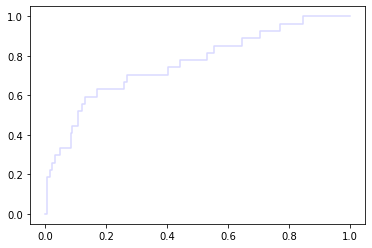

In [174]:
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

# EDIT MODEL PATHS TO USE
models = {0: '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/cough_speech_models/0/010--0.212--0.173.hdf5'
          #1: '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/cough_speech_models/1/013--0.277--0.220.hdf5',
          #2: '/home/sumukhmlohit/my_project_dir/virufy-covid/cough_speech_models/2/020--0.503--0.098.hdf5',
          #3: '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/cough_speech_models/3/020--0.299--0.075.hdf5',
          #4: '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/cough_speech_models/4/016--0.254--0.192.hdf5'
          }

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(5):
  print(iii)

  test_features= DATA[iii]['MFCCS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_extra   = DATA[iii]['EXTRA'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_imgs    = DATA[iii]['MEL'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_labels  = DATA[iii]['LABELS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_imgsp,test_featuresp,test_imgsb,test_featuresb,test_labels,batch_size=48,target_size=(64,64))

  model = keras.models.load_model(models[iii])
  y_score = model.predict(TEST)
  fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
  print('Num_samples:', len(y_score))

  print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))

  plt.plot(fpr, tpr, 'b', alpha=0.15)
  tpr = interp(base_fpr, fpr, tpr)
  tpr[0] = 0.0
  tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('roc_curve.png')
plt.show()

In [164]:
from keras.models import load_model
model = keras.models.load_model('/home/sumukhmlohit/my_project_dir/virufy-covid/cough/cough_speech_models/2/011--0.229--0.226.hdf5')
y_score = model.predict(TEST)
fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
print('Num_samples:', len(y_score))
print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))


Num_samples: 240
acc:  0.925


In [155]:
import librosa.display

In [4]:
def feature_extractor1(row):

  name     = row[0]
  try:
    audio,sr = librosa.load(row[1])
    #For MFCCS 
    mfccs    = librosa.feature.mfcc(y=audio,sr=sr, n_mfcc=39)
    mfccsscaled = np.mean(mfccs.T,axis=0)
    
    #Mel Spectogram
    plt.axis('off') # no axis
    plt.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
    melspec  = librosa.feature.melspectrogram(y=audio,sr=sr)
    s_db     = librosa.power_to_db(melspec, ref=np.max)
    librosa.display.specshow(s_db)

    savepath = os.path.join(custpath,name+'.png')
    plt.savefig(savepath, bbox_inches=None, pad_inches=0)
    plt.close()
  except:
    print('File cannot open')
    return None,None
  return mfccsscaled,savepath

features = []
diagnoses= []
imgpaths = []

In [45]:
custpath='/home/sumukhmlohit/my_project_dir/virufy-covid/cough/custom_input'
#row='/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200413/vK2bLRNzllXNeyOMudnNSL5cfpG2/breathing-shallow.wav'
#row='/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200820/TaoyZAahOzRoDQRxb0DtDZh8Opa2/cough-shallow.wav'
row=['IimA0GnOm7ZR4nEr8k0kG4eaR7A3','/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20201221/CUCqq4q5SQa3fDkpraekej7fNza2/cough-shallow.wav',0,1]

mfccs,savepath  = feature_extractor1(row)
features.append(mfccs)
imgpaths.append(savepath)
diagnoses.append([row[2],row[3]])

In [46]:
row

['IimA0GnOm7ZR4nEr8k0kG4eaR7A3',
 '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20201221/CUCqq4q5SQa3fDkpraekej7fNza2/cough-shallow.wav',
 0,
 1]

In [29]:
cd '/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200413/vK2bLRNzllXNeyOMudnNSL5cfpG2/'

/home/sumukhmlohit/my_project_dir/virufy-covid/cough/Coswara-Data/20200413/vK2bLRNzllXNeyOMudnNSL5cfpG2


In [41]:
cd '/home/sumukhmlohit/my_project_dir/virufy-covid/cough'

/home/sumukhmlohit/my_project_dir/virufy-covid/cough


In [42]:
ls

Coswara-Data/          count_covid.ipynb           model.h5
Untitled.ipynb         custom_dataset/             models/
Untitled1.ipynb        custom_dataset_breathing/   models1/
Untitled2.ipynb        custom_dataset_count_fast/  predict_cough.ipynb
breathing_covid.ipynb  custom_input/               public_dataset/
breathing_models/      fast_count_models/          public_dataset.zip
cough_model.ipynb      loaded_data.pickle          roc_curve.png
cough_model.py         loaded_data.pickle_count


In [47]:
tfeaturesd = np.array([mfccs for i in range(48)])
timgsd = np.array([savepath for i in range(48)])
textrad = np.array([[row[2],row[3]] for i in range(48)])
labelsd = np.array([1 for i in range(48)])

In [48]:
tfeaturesd.shape

(48, 39)

In [49]:
custom = TripleInputGenerator(tfeaturesd,timgsd,textrad,labelsd,batch_size=48,target_size=(64,64))

In [52]:
y_score1

array([[0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134],
       [0.5856134]], dtype=float32)

In [51]:
y_score1=model.predict_generator(custom)
y_score1
x=y_score1>0.5

In [53]:
if x[0][0]==True:
    print('Positive')
else:
    print('Healthy')

Positive
